# Lab session 2: Language modeling

This lab covers classical and neural language models as seen in the theory lectures. 

General instructions:
- Complete the code where needed
- Provide answers to questions only in the cell where indicated
- **Do not alter the evaluation cells** (`## evaluation`) in any way as they are needed for the partly automated evaluation process

## **How AI can write a paper!**

We shall train our language model on a corpora of scientific articles and see if we can generate a new one!

<img src="https://media1.tenor.com/images/073dfe5d68e2490903aa51ae0ac633de/tenor.gif?itemid=3536848" alt="img" width="512px"/>



In [0]:
# import necessary packages

from __future__ import division
from __future__ import unicode_literals

import random as rand
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [0]:
# for reproducability
SEED = 42
np.random.seed(SEED)

### **Data exploration**

Lets download and look into the data:


In [3]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2020-03-17 18:40:00--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2020-03-17 18:40:00--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5a6eb7fa5a70a1548b52b84503.dl.dropboxusercontent.com/cd/0/get/A0HdI_Tz83vOs8JjUXLF1bxP79ykjHxTHhPWIsuaz2iiuWzw76BsR3XjsgLL9_kudfKpnDpNF9JbWP0w22l-bO7FF-gJlRXQUNnhXJr6eQ0xlQ/file?dl=1# [following]
--2020-03-17 18:40:01--  https://uc5a6eb7fa5a70a1548b52b84503.dl.dropboxusercontent.com/cd/0/get/A0HdI_Tz83vOs8JjUXLF1bxP79ykjHxTHhPWIsuaz2iiuWzw76BsR3XjsgLL9_kudfKpnDpNF9JbWP0w22l-bO7FF-gJlRXQUNnhXJr

,author,day,id,link,month,summary,tag,title,year
857,"[{'name': 'A. N. Gorban'}, {'name': 'A. Y. Zin...",2,0809.0490v2,"[{'rel': 'related', 'href': 'http://dx.doi.org...",9,"In many physical, statistical, biological and ...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Principal Graphs and Manifolds,2008
144,"[{'name': 'Behnam Neyshabur'}, {'name': 'Ryota...",27,1503.00036v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,"We investigate the capacity, convexity and cha...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Norm-Based Capacity Control in Neural Networks,2015
22961,"[{'name': 'Maria De-Arteaga'}, {'name': 'Willi...",27,1711.09522v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,This is the Proceedings of NIPS 2017 Workshop ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Proceedings of NIPS 2017 Workshop on Machine L...,2017
19448,"[{'name': 'J. Keppens'}, {'name': 'Q. Shen'}]",30,1107.0035v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",6,The predominant knowledge-based approach to au...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Compositional Model Repositories via Dynamic C...,2011
2331,"[{'name': 'Kevin T. Kelly'}, {'name': 'Conor M...",15,1203.3488v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,"Over the past two decades, several consistent ...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Causal Conclusions that Flip Repeatedly and Th...,2012


In [4]:
# Assemble lines: concatenate title and description
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'], axis=1).tolist()

# Sample the first 3 lines...
sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

In [5]:
# Convert lines into strings of space-separated tokens
from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()
lines = [tknzr.tokenize(sent.lower()) for sent in lines]
lines = [' '.join(sent) for sent in lines]

sorted(lines, key=len)[:3]

['differential contrastive divergence ; this paper has been retracted .',
 'what does artificial life tell us about death ? ; short philosophical essay',
 'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .']

### **N-Gram Language Model**

A language model is a probabilistic model that estimates text probability: the joint probability of all tokens $w_t$ in text $X$: $P(X) = P(w_1, \dots, w_T)$.

It can do so by following the chain rule:
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$ 

The problem with such approach is that the final term $P(w_T \mid w_1, \dots, w_{T-1})$ depends on $n-1$ previous words. This probability is impractical to estimate for long texts, e.g. $T = 1000$.

One popular approximation is to assume that the next word only depends on a finite amount of previous words:

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Such a model is called an __n-gram language model__ where n is a parameter. For example, in 3-gram language model, each word only depends on the 2 previous words. 

$$
    P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

You can also sometimes see that approximation under the name of the _n-th order markov assumption_.

The first stage in building such a model is counting all word occurences given the $n-1$ previous words:

In [0]:
from collections import defaultdict, Counter

# special tokens: 
# - unk represents absent tokens, 
# - eos is a special token after the end of sequence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occured after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}

    When building counts, please consider the following two edge cases
    - if prefix is shorter than (n - 1) tokens, it should be padded with UNK. For n=3,
      empty prefix: "" -> (UNK, UNK)
      short prefix: "the" -> (UNK, the)
      long prefix: "the new approach" -> (new, approach)
    - you should add a special token, EOS, at the end of each sequence
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      count the probability of this token just like all others.
    """
    
    counts = defaultdict(Counter)
      
    # counts[(word 1, word 2 ... word n-1)][word n] 
    #    = how many times word n occurred after (word 1 ... word n-1)
    
    for sent in lines:
        sent = sent.split() + [EOS]
        prefix = [UNK] * (n-1)
        for word in sent:
            ############### for student ################
            counts[tuple(prefix)][word] +=1
            if len(prefix) > 0:
              prefix.pop(0)
              prefix.append(word)
            ############################################

    return counts

In [7]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
assert dummy_counts['author', '.']['_EOS_'] == 1
assert dummy_counts['p', '=']['np'] == 2
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3

print('well done!')

well done!


Once we can count N-grams, we can build a probabilistic language model.
The simplest way to compute probabilities is in proporiton to counts:

$$ P(w | \textit{prefix}) = { \textit{Count}(\textit{prefix}, w) \over \sum_{w' \in \textit{Vocab}} \textit{Count}(\textit{prefix}, w') } $$

In [0]:
class NGramLanguageModel:    
    def __init__(self, lines, n):
        """ 
        Train a simple count-based language model: 
        compute probabilities P(w | prefix) given n-gram counts
        
        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n
    
        counts = count_ngrams(lines, self.n)
        self.probs = defaultdict(Counter)
        
        # compute token probabilities (self.probs), given the counts computed above
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)
        ############### for student ################
        for sent in lines:
          sent = sent.split() + [EOS]
          prefix = [UNK] * (n-1)
          for word in sent:
            sum = 0
            for count in counts[tuple(prefix)].values():
              sum += count
            self.probs[tuple(prefix)][word] = counts[tuple(prefix)][word] / sum
            if len(prefix) > 0:
              prefix.pop(0)
              prefix.append(word)
        ############################################

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : its probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Let's test it!

In [9]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

print("Good job!")

Good job!


Now that you've got a working n-gram language model, let's see what sequences it can generate. But first, let's train it on the whole dataset.

In [0]:
lm = NGramLanguageModel(lines, n=3)

The process of generating sequences is... well, it's sequential. You maintain a list of tokens and iteratively add the next token by sampling from the probabilities over the vocabulary at each point in the sequence.

$ X = [] $

__forever:__
* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$


Instead of sampling with probabilities, one can also take the most likely token, sample from among the top-K most likely tokens, or sample with a certain *temperature*. In the latter case (temperature), one samples from

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau}}$$

Where $\tau > 0$ is the model temperature. If $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish. For sampling from a given probability distribution, the function `np.random.choice` can be used.

In [0]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """

    ############### for student ################ 
    if temperature == 0:
      inverse_temperature = 1
    else:
      inverse_temperature = 1 / temperature

    possible_next_tokens = lm.get_possible_next_tokens(prefix)
    probs_dict = {}
    sum = 0
    for possible_next_token in possible_next_tokens:
      next_token_prob = lm.get_next_token_prob(prefix, possible_next_token)
      next_token_prob_with_temperature = pow(next_token_prob, inverse_temperature)
      probs_dict[possible_next_token] = next_token_prob_with_temperature
      sum += next_token_prob_with_temperature


    keys =  list(probs_dict.keys())
    values = [value / sum for value in list(probs_dict.values())]

    if temperature == 0:
      max_indices = np.where(values == np.amax(values))[0]
      token = keys[np.random.choice(max_indices)]
    else:
      token = np.random.choice(keys, p=values)
    ############################################

    return token           


In [12]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200
test_freqs = Counter([get_next_token(lm, 'deep', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000

print("Looks nice!")

Looks nice!


Let's have fun with this model:

In [13]:
prefix = 'artificial' # <- your ideas on the start of your AI generated scientific paper :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

artificial persuasion in abstract argumentation frameworks . this work , we use a technique to solve this problem has been successful in extracting organization names in various real - world data regression problems ; to solve the problem defaults were intended to cause parameters to be adopted , where there are still subject to some state - observation model by allowing nonmonotonic inferences and show distribution - independent behaviors . we evaluate the performance of each position . over - segmentation to assign dependency relation matrix , and can solve various fault detection problems arising in random experiments . _EOS_


In [14]:
prefix = 'bridging the' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.4)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

bridging the gap between the amount of data mining , and it is possible to train a deep neural networks ( cnns ) and the results of a set of labeled data for the task of learning the parameters of the proposed method is significantly faster than the original data set . we show that the proposed method . _EOS_


### Question:
1. How does the temperature parameter affect the generated samples?

When the temperature is very small, more likely tokens will be sampled with an even higher probability.
There will be a lower chance of getting 'exotic' words and sentences.

### **Evaluating language models: perplexity**

Perplexity is a measure of how well does your model approximate true probability distribution behind data. __Smaller perplexity = better model__.

To compute perplexity on one sentence, use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


On the corpus level, perplexity is a product of probabilities of all tokens in all sentences to the power of 1, divided by __total length of all sentences__ in corpora.

This number can quickly get too small for float32/float64 precision, so we recommend you to first compute log-perplexity (from log-probabilities) and then take the exponent.

In [0]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprob, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """
    N = 0  # number of tokens
    ppl = 0.0 # perplexity
    
    # https://stats.stackexchange.com/questions/129352/how-to-find-the-perplexity-of-a-corpus
    
    ############### for student ################
    sum = 0
    for sent in lines:
      # calculate sentence probability
      sent_log_prob = 0
      sent = sent.split() + [EOS]
      prefix = [UNK] * (lm.n-1)
      for word in sent:
        N += 1
        word_prob = lm.get_next_token_prob(" ".join(prefix), word)
        if word_prob == 0:
          sent_log_prob += min_logprob
        else:
          sent_log_prob += max(min_logprob, np.log(word_prob))
        if len(prefix) > 0:
          prefix.pop(0)
          prefix.append(word)

      # update sum with sentence log probability or
      sum += sent_log_prob

    # calculate perplexity
    ppl = np.exp(-1/N * sum)
    ############################################
    
    return ppl

In [16]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be nonnegative and reasonably small"
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert ppx1 > ppx3 > ppx10, "higher N-gram models should overfit and have lower ppl"

assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

print('Well done!')

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184
Well done!


Now let's measure the actual perplexity: we'll split the data into train and test and score model on test data only.

In [17]:
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=SEED)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


KeyboardInterrupt: ignored

### Question:

2. Do you expect increasing/decreasing perplexities for language models with longer n-grams (i.e., higher values of n)? Does this correspond with the test output you observe above? If not: can you explain this?

The longer the n-gram, the lower the perplexity on the train set.
When n becomes to big, too many sequences of words have nog been seen yet, so the results will get worse.


###  LM Smoothing

The problem with our simple language model is that whenever it encounters an n-gram it has never seen before, it assigns it the probabilitiy of 0. Every time this happens, perplexity explodes.
To battle this issue, there's a technique called __smoothing__. 

The core idea is to modify counts in a way that prevents probabilities from getting too low. The simplest algorithm here is _additive smoothing_ (aka [Lapace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)):

$$ P(w | \textit{prefix}) = \frac{\textit{Count}(\textit{prefix}, w) \color{red}{+ \delta}}{\sum_{w' \in \textit{Vocab}}(\textit{Count}(\textit{prefix}, w') \color{red}{+ \delta})} $$

If counts for a given prefix are low, additive smoothing will adjust probabilities to a more uniform distribution.

Update `self.probs` inside the `__init__` to handle smoothing. 

In [0]:
class LaplaceLanguageModel(NGramLanguageModel): 
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n) # 
        self.vocab = set(token for token_counts in counts.values() for token in token_counts) #
        self.probs = defaultdict(Counter)
        
        # compute token proabilities
        # probs[prefix][token] = ...
        ############### for student ################
        for sent in lines:
          sent = sent.split() + [EOS]
          prefix = [UNK] * (n-1)
          for word in sent:
            sum = 0
            for count in counts[tuple(prefix)].values():
              sum += count
            self.probs[tuple(prefix)][word] = (counts[tuple(prefix)][word] + delta) / (sum + len(self.vocab)*delta)
            if len(prefix) > 0:
              prefix.pop(0)
              prefix.append(word)
        ############################################

    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}
        


    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        

In [19]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = LaplaceLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "You broke something ! :)"

print('Great!')

Great!


In [20]:
# calculate perplexity for LaplaceLanguageModel

from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=SEED)

for n in (1, 2, 3):
    lm = LaplaceLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

KeyboardInterrupt: ignored

### Question:
3.   In a bigram language model (without smoothing), which of the following two phrases do you expect to have higher probablity? Why?
 - *and and*
 - *this paper* 

The probability of "and and" is expected to be zero, as it is not part of the valid english grammar.
The sequence "this paper" can appear in the corpus, so the probability is expected to be higher than 0, and thus also expected to higher than that of "and and".

 4.   If we add smoothing, how would the probability relation change for the above phrases? 

The probability of "and and" will be higher than 0, but still lower than that of "this paper".

Train both language models (smoothing and non-smoothing version) on `dummy_lines` and report perplexity for the given phrases.

In [21]:
lm_names = ["without smoothing", "with smoothing"]
phrases = [["and and"], ["this paper"]]

############### for student ################
ngram = NGramLanguageModel(n=2, lines=dummy_lines)
laplace = LaplaceLanguageModel(n=2, lines=dummy_lines)
models = [ngram, laplace]

for phrase in phrases:
  for model, lm_name in zip(models, lm_names):
      ppl = perplexity(model, phrase)
      ############################################
      print("%s: phrase = '%s' --> pp = %.2E" % (lm_name, phrase, ppl))
        

without smoothing: phrase = '['and and']' --> pp = 1.00E+50
with smoothing: phrase = '['and and']' --> pp = 1.01E+03
without smoothing: phrase = '['this paper']' --> pp = 2.79E+33
with smoothing: phrase = '['this paper']' --> pp = 3.48E+02


## **Deep Learning Based Language Models**

We've checked out statistical approaches to language models so far. Now let's go find out what deep learning has to offer. We're gonna use the same dataset as before. 


![alt text](https://vipulvaibhaw.files.wordpress.com/2019/04/saltbae_pytorch.jpg)



We are going to implement the simplest recurrent neural network (RNN) known as the Elman RNN. Its hidden state aims to encapsulate the information for all previous input elements in order to help the network to take into account *the past*. Since there is no hidden state during the first step, we feed the network with an initial state of zero values (or randomly initilized values). Next, we feed it the first token $\textit{A}$ together with the hidden state of the previous step, to predcit the next output ($\textit{girl}$). We'll repeat this procudure until the end of sequence. 

We can summarize the above explanation into a simple equation as:

$$h_t = F(x_{t}, h_{t-1}) = f(W_{x}x_t + W_{h}h_{t-1} + b),$$

where $x_{t}$ is input, $h_{t}$ is hidden state, $b$ is bias term and $f$ is the `tanh` non-linearity.

<a href="https://ibb.co/TcWR5CQ"><img src="https://adventuresinmachinelearning.com/wp-content/uploads/2017/09/Recurrent-neural-network.png" border="0"></a>

In [22]:
### If you don't have pytorch yet: install it in the current kernel first.
### Uncomment next 2 lines to do that.
import sys
!conda install --yes --prefix {sys.prefix} pytorch

# first import necessary packages
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/bin/bash: conda: command not found
cuda


### **Tokenization**

Before implementing the neural network itself, lets prepare the data. We need special tokens:

* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [0]:
BOS, EOS = '<s>', '</s>'
text = [BOS + ' ' + line + ' ' + EOS for line in lines] # concatenate BOS and EOS to all sentences
text = [line.split() for line in text]

In [24]:
# let's print the first sentence 
print(text[0])

['<s>', 'dual', 'recurrent', 'attention', 'units', 'for', 'visual', 'question', 'answering', ';', 'we', 'propose', 'an', 'architecture', 'for', 'vqa', 'which', 'utilizes', 'recurrent', 'layers', 'to', 'generate', 'visual', 'and', 'textual', 'attention', '.', 'the', 'memory', 'characteristic', 'of', 'the', 'proposed', 'recurrent', 'attention', 'units', 'offers', 'a', 'rich', 'joint', 'embedding', 'of', 'visual', 'and', 'textual', 'features', 'and', 'enables', 'the', 'model', 'to', 'reason', 'relations', 'between', 'several', 'parts', 'of', 'the', 'image', 'and', 'question', '.', 'our', 'single', 'model', 'outperforms', 'the', 'first', 'place', 'winner', 'on', 'the', 'vqa', '1', '.', '0', 'dataset', ',', 'performs', 'within', 'margin', 'to', 'the', 'current', 'state', '-', 'of', '-', 'the', '-', 'art', 'ensemble', 'model', '.', 'we', 'also', 'experiment', 'with', 'replacing', 'attention', 'mechanisms', 'in', 'other', 'state', '-', 'of', '-', 'the', '-', 'art', 'models', 'with', 'our', 'i

Let us convert our raw text into sequences of ids. First, create two sorted dictionaries and map each token to an id. Second, create the target data sequences based on the input. Note that the target is the same as the input, except that it is one token ahead of the input.

In [0]:
from collections import Counter

def get_data_lm(data):
    
    word_counts = Counter()
    for sent in data:
        word_counts.update(sent)

    sorted_token = sorted(word_counts, key=word_counts.get, reverse=True)
    
    # create two dictionaries to convert token to id or vice-verca
    id_to_token = {k: w for k, w in enumerate(sorted_token)}
    token_to_id = {w: k for k, w in id_to_token.items()}
    
    n_token = len(id_to_token)
    
    tokenized_text = [[token_to_id[w] for w in sent] for sent in data]
    
    # output is one token ahead
    inp_text = [sent[:-1] for sent in tokenized_text]
    out_text = [sent[1: ] for sent in tokenized_text]

    return id_to_token, token_to_id, n_token, inp_text, out_text

In [26]:
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(text[0:1])

print("-- raw text:", text[0:1])
print('-' * 100)
print("-- input text:", inp_text)
print('-' * 100)
print("-- output text:", out_text)

-- raw text: [['<s>', 'dual', 'recurrent', 'attention', 'units', 'for', 'visual', 'question', 'answering', ';', 'we', 'propose', 'an', 'architecture', 'for', 'vqa', 'which', 'utilizes', 'recurrent', 'layers', 'to', 'generate', 'visual', 'and', 'textual', 'attention', '.', 'the', 'memory', 'characteristic', 'of', 'the', 'proposed', 'recurrent', 'attention', 'units', 'offers', 'a', 'rich', 'joint', 'embedding', 'of', 'visual', 'and', 'textual', 'features', 'and', 'enables', 'the', 'model', 'to', 'reason', 'relations', 'between', 'several', 'parts', 'of', 'the', 'image', 'and', 'question', '.', 'our', 'single', 'model', 'outperforms', 'the', 'first', 'place', 'winner', 'on', 'the', 'vqa', '1', '.', '0', 'dataset', ',', 'performs', 'within', 'margin', 'to', 'the', 'current', 'state', '-', 'of', '-', 'the', '-', 'art', 'ensemble', 'model', '.', 'we', 'also', 'experiment', 'with', 'replacing', 'attention', 'mechanisms', 'in', 'other', 'state', '-', 'of', '-', 'the', '-', 'art', 'models', 'wi

For training, we won't put the entire sequence through the model at once. As explained in the theory lectures, we will limit the sequence length over which we apply back-propagation (which we'll call the *bptt*, or the back-propagation-through-time length), and arrange the bptt-long segments into mini-batches for parallel training (also see the slides, for considerations on choosing the mini-batch size).

Let us first convert the sequences into **mini-batches**

Suppose our batch size is 4 (for benefiting from a gpu, you'll need to scale this up), bptt is 3 (in practice it will be much longer, though), and our data consists of a 1-dimensional tensor containing 36 token id's. Each batch will contain a 4x3 input tensor and a 4x3 target tensor, except for the last batch (we can discard the last one during training). As you already know, the target batch is one token ahead (in terms of the original sequence) of the input batch since our task is language modeling! The input/output tensor for the first batch will be something like the following:

**Input batch**:

![alt text](https://miro.medium.com/max/522/1*DVCsHtcfX8Hrb-1BJg92fw.png)

**Target batch**:

![alt text](https://miro.medium.com/max/504/1*gczU2zRHXnQ0SgXLanIK9g.png)

We'll convert the input (`inp_text`) and target (`out_text`) indices from the previous steps into mini-batches as follows:

In [0]:
from itertools import chain 
from sklearn.utils import shuffle

def get_batches(inp_text, out_text, batch_size, seq_size):
    
    # shuffle the sentences
    itext, otext = shuffle(inp_text, out_text)
    
    # flatten the data
    itext = list(chain(*itext))
    otext = list(chain(*otext))
    
    # work out how cleanly we can divide the dataset into batch_size parts.
    num_batches = int(len(itext) / (seq_size * batch_size))
    
    # trim off any extra elements that wouldn't cleanly fit
    itext = itext[:num_batches * batch_size * seq_size] 
    otext = otext[:num_batches * batch_size * seq_size]

    itext = np.reshape(itext, (batch_size, -1)) # batch_size * tokens
    otext = np.reshape(otext, (batch_size, -1)) # batch_size * tokens
    
    for i in range(0, num_batches * seq_size, seq_size):
        yield itext[:, i:i + seq_size], otext[:, i:i + seq_size]

### Question:
5.   Does trimming, in above, reduce capabilites of the train model?

NO

In [28]:
bs = 4
bptt = 10
batches = get_batches(inp_text, out_text, bs, bptt)

for x,y in batches:
    print('input:', x.shape)
    print(x)
    print('-' * 35)
    print('target:', y.shape)
    print(y)
    break;

input: (4, 10)
[[24 25  6  3 13 14  7 15 26 27]
 [ 5  0 37  6  3 13 38 39 40 41]
 [15  1 11 51 10 52  0 53 54 55]
 [22 62 10  1 16 63 64 23 65  3]]
-----------------------------------
target: (4, 10)
[[25  6  3 13 14  7 15 26 27 16]
 [ 0 37  6  3 13 38 39 40 41 42]
 [ 1 11 51 10 52  0 53 54 55 18]
 [62 10  1 16 63 64 23 65  3 66]]


### **Let's build the model**

By extending the `nn.Module` you can easily develop your own recurrent cell in pytorch. In this part we shall implement **Elman** Recurrent Network. This module receives a sequence of feature vectors and returns two tensors. Please study the nodes as defined in `__init__` and initialized using `init_weights`, and correctly fill in the `forward` method in line with the formula for the Elman RNN. 


In [0]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super(RNN, self).__init__()
        # necessary parameters in Elman RNN
        self.input_sz = input_sz
        self.hidden_sz = hidden_sz
        
        self.fc_x = nn.Linear(self.input_sz, self.hidden_sz, bias=False)
        self.fc_h = nn.Linear(self.hidden_sz, self.hidden_sz) #default: bias = True
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.fc_x.weight)
        nn.init.xavier_uniform_(self.fc_h.weight)
        self.fc_h.bias.data.fill_(0.0)

    def forward(self, x, state=None):
        """
        :param x: batch of sequences of input symbols (represented as vectors)
                  dimensions of x will be batch_size * sequence_length * input_sz
        :param state: state vector, of size self.hidden_sz
        :return: hidden_seq, state; where state is final output state,
                 hidden_seq is list of hidden states h_t (see fig. above)
        """
        
        # things to do:
        # 1) if state is None, initialize it with zeros (use `torch.zeros`)
        # 2) iterate over time, each time applying the RNN formula, and
        #    concatenate the state tensors to hidden_seq (with `torch.cat`)
        # 3) reshape hidden_seq from (seq, batch, feature) to (batch, seq, feature), with `Tensor.transpose`
        
        hidden_seq = []
        
        ############### for student ################
        if state == None:
          state = torch.zeros((x.size(0),self.hidden_sz)).to(device)
        
        x = x.permute(1,0,2)
        time_steps = x.size(0)
        for t in range(time_steps):
            state = torch.tanh(self.fc_x(x[t]) + self.fc_h(state))
            hidden_seq.append(state)
        ############################################

        out = torch.stack(hidden_seq)
        out = out.permute(1,0,2)
        
        return out, state

In [30]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the RNN module
arr = torch.rand([1, 2, 2]).to(device) # tensor dimension: batch size x bptt x features
my_rnn = RNN(2, 2).to(device)
out, state = my_rnn(arr)

assert out.shape == torch.Size([1, 2, 2]), out.shape
assert state.shape == torch.Size([1, 2]), state.shape

print("RNNCell completed!")

RNNCell completed!


The recurrent module is only one part of the neural language model, we still need an embedding layer to convert our tokens into a feature vector and a decoding layer to predict subsequent tokens. To this end, we defined a wrapper and put everything in it. We provided the necessary modules you'll need, please complete the `forward` function. 

In [0]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens, hidden_size):
        super(RNNLanguageModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Embedding(n_tokens, hidden_size)  
        self.rnn = RNN(hidden_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, n_tokens)
    
    def forward(self, x, prev_state):
        """
        :return: logits, state; where logits = output of the decoder,
                 and state = the final rnn state.
        """
        # call the Embedding, RNN and linear decoder layer in the forward pass
        ############### for student ################
        embeddings = self.encoder(x)
        out, state = self.rnn(embeddings)
        logits = self.decoder(out)

        return logits, state
        ############################################        

    def zero_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)



In [32]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the whole model
arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)

rnn_language_model = RNNLanguageModel(n_token, 256).to(device)
state = rnn_language_model.zero_state(64).to(device)
out, state = rnn_language_model(arr, state)

assert type(out) != type(None), 'Do you return output?'
assert type(state) != type(None), 'Do you return state?'
assert out.shape == torch.Size([64, 32, n_token]), out.shape
assert state.shape == torch.Size([64, 256]), state.shape 
print("Sounds good! The model is complete!")

Sounds good! The model is complete!


### **Sampling**

You will need a function to generate text. For your convenience, we implemented it for you. The idea is to feed one token at a time to the model and concatenate the model's output token to previously predicted tokens. 


In [0]:
def sample(preds, n_token, temperature):
    if temperature == 0:
        choice = np.argmax(preds[0].tolist())
    else:
        preds = preds.squeeze() / temperature
        exp_preds = np.exp(preds.tolist())
        preds = exp_preds / np.sum(exp_preds)
        choice = np.random.choice([*range(n_token)], p=preds)
    return choice

In [0]:
def generate_text(device, net, n_token, token_to_id, id_to_token, temperature=1.0):
    # we are in evaluation mode
    net.eval()

    # initialize state
    state_h = net.zero_state(1).to(device)

    # manually feed some tokens
    initial_words = ['recurrent', 'neural']
    for w in initial_words:
        ix = torch.tensor([[token_to_id[w]]], dtype=torch.long).to(device)
        preds, state_h = net(ix, state_h)
    
    choice = sample(preds, n_token, temperature)
    initial_words.append(id_to_token[choice])

    # generate next tokens (50 tokens at most!)
    for _ in range(50):
        ix = torch.tensor([[choice]], dtype=torch.long).to(device)
        preds, state_h = net(ix, state_h)
        choice = sample(preds, n_token, temperature)
        
#         # you can stop generation 
#         if id_to_token[choice] == EOS:
#             break;
        
        initial_words.append(id_to_token[choice])


    return ' '.join(initial_words)

### **Training loop**

A typical set of steps for training in Pytorch is:

* set model in 'train' mode *(note: it will only inform the inner mechanism that we are about to train, but not actually execute the training; we still need to do that ourselves)*
* Reset all gradients
* Compute output, loss value, accuracy, etc
* Perform back-propagation
* Update the network’s parameters

In [0]:
seq_size = 32
batch_size = 16
hidden_size = 256
temperature = 1.0

dummy_text = text[0:100]
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)

In [36]:
net = RNNLanguageModel(n_token, hidden_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

iteration = 0
total_epochs = 100
loss_history = []


for e in range(total_epochs):
    
    batches = get_batches(inp_text, out_text, batch_size, seq_size)
    
    state_h = net.zero_state(batch_size)
    state_h = state_h.to(device)
    
    for x, y in batches:
        iteration += 1

        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)

        # Things to do:
        # - put model in `train` mode
        # - set gradients to zero
        # - model prediction for given input
        # - calculate loss for a mini-batch
        # - compute gradient
        # - detach state representation by `detach()` (If we did not detach the history of hidden states 
        #   the back-propagated gradients would flow from the loss towards the beginning)
        # - clip gradients (optional)
        # - update parameters 
        
        ############### for student ################
        net.train()
        optimizer.zero_grad()
        prediction, state_h = net(x, state_h)
        prediction = prediction.permute(0,2,1)
        loss = criterion(prediction, y)
        loss.backward()
        state_h.detach()
        optimizer.step()
        ############################################

        if iteration % 50 == 0:
            print('epoch: {}/{} iteration: {} loss: {}'.format(e, total_epochs, iteration, loss.item()))
            
        if iteration % 250 == 0:
            print('-' * 50)
            print(generate_text(device, net, n_token, token_to_id, id_to_token, temperature))
            print('-' * 50)
    
    loss_history.append(loss.item())

epoch: 1/100 iteration: 50 loss: 6.073951721191406
epoch: 2/100 iteration: 100 loss: 5.4057159423828125
epoch: 4/100 iteration: 150 loss: 4.830307960510254
epoch: 5/100 iteration: 200 loss: 4.531630992889404
epoch: 6/100 iteration: 250 loss: 4.179226398468018
--------------------------------------------------
recurrent neural networks ? ), dependence corresponding engineering dnns reading insights insurance adoption platforms leverage free 2009 limiting knowledge shows second phi specifications obtains its saved dialogue response generation have been issues scholarly augments visualizing object memory implemented reliable forcing correlate only scratch implemented ones the current service dialogues barely utterances acquire reduce
--------------------------------------------------
epoch: 8/100 iteration: 300 loss: 3.6311163902282715
epoch: 9/100 iteration: 350 loss: 3.5736477375030518
epoch: 11/100 iteration: 400 loss: 3.075451374053955
epoch: 12/100 iteration: 450 loss: 2.730636596679

In [37]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

assert sum(loss_history) / len(loss_history) < 2.0
assert loss_history[-1] < 1.0

print('Fantastico!')

Fantastico!


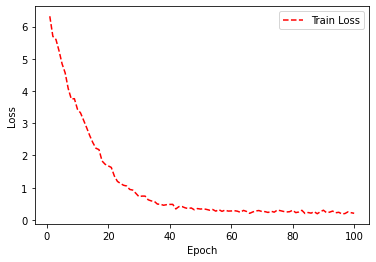

In [38]:
epoch_count = range(1, len(loss_history) + 1) 

# Visualize loss history
plt.plot(epoch_count, loss_history, 'r--')
plt.legend(['Train Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### **More powerful cell!**

In previous part, we implemented a simple Elman recurrent network. We can easily extend it to an **LSTM** by modifying our code slightly. Since we already learned how to implement the recurrent cell itself, in this part, we will simply use the existing pytorch `nn.LSTM` implementation. One major difference between these two networks is their **hidden state**. Unlike an Elman RNN which has just a single state, the hidden state of LSTM is made up of two parts.
Please take a look at the online documentation of [`nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) as well as [`nn.LSTMCell`](https://pytorch.org/docs/stable/nn.html?highlight=lstmcell#torch.nn.LSTMCell)

<img src="https://www.knime.com/sites/default/files/fig_2_2.png" alt="img" width="512px"/>

In [0]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, n_tokens, hidden_sz):
        super(LSTMLanguageModel, self).__init__()
        self.hidden_size = hidden_sz
        
        self.embedding = nn.Embedding(n_tokens, hidden_sz)
        self.rnn = nn.LSTM(hidden_sz, hidden_sz, batch_first=True)
        self.decoder = nn.Linear(hidden_sz, n_tokens)
        
    def forward(self, x, prev_state):
        """
        :return: logits, state; where logits is output of the decoder,
                 and state is the final rnn state.
        """
        ############### for student ################
        embeddings = self.embedding(x)
        out, (state_h, state_c) = self.rnn(embeddings, prev_state)
        logits = self.decoder(out)

        return logits, (state_h, state_c)
        ############################################
    
    def zero_state(self, batch_size, dev):
        # look up the dimensions of the nn.LSTM state (which is a tuple!)
        # write code to return a zero-initialized state (make use of torch.zeros(...))
        # already put on the correct device (dev)
        ############### for student ################
        return (torch.zeros(1, batch_size, self.hidden_size).to(dev), torch.zeros(1, batch_size, self.hidden_size).to(device))
        ############################################

In [40]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the LSTM model
arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)
model = LSTMLanguageModel(n_token, 256).to(device)
state = model.zero_state(64, device)
out, state = model(arr, state)

assert type(out) != type(None), 'Did you return output?'
assert type(state) != type(None), 'How about state?'
assert out.shape == torch.Size([64, 32, n_token]), out.shape
assert isinstance(state, tuple) 
print("LSTM is complete! Perfect!")

LSTM is complete! Perfect!


### **Evaluation method**

As you may already notice, in previous part, each time we wanted to measure the loss we evaluate it only for a mini-batch which is not an elegant way to do it. Let's create an evaluation method to put everything inside it.  

Complete the __evaluate()__ method to return the overall (mean) cross-entropy loss. 

In [0]:
def evaluate(device, net, n_token, batch_size, seq_size, x_test, y_test):
    
    net.eval()
    
    total_loss = 0.
    
    # intialize state
    (state_h, state_c) = net.zero_state(batch_size, device)
    
    # batchify data
    batches = get_batches(x_test, y_test, batch_size, seq_size)
    
    # loop throgh the batchify data 
    # use 'criterion' to calculate loss
    # detach() states
    # return loss
    ############### for student ################
    n_batches = 0
    for x, y in batches:
        n_batches += 1
        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)
        
        prediction, (state_h, state_c) = net(x, (state_h, state_c))
        prediction = prediction.permute(0,2,1)
        loss = criterion(prediction, y)
        state_h.detach()
        state_c.detach()
        total_loss += loss.item()

    return total_loss / n_batches
    ############################################

In [42]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
net = LSTMLanguageModel(n_token, 256).to(device)
dummy_loss = evaluate(device, net, n_token, 10, 64, inp_text, out_text)

assert np.exp(dummy_loss) < 1e4, 'your dummy ppl is too large!'

print("It sounds good")

It sounds good


### Train on whole dataset

Lets train the model on the whole train set this time:

In [0]:
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
X_train, X_test, y_train, y_test = train_test_split(inp_text, out_text, test_size=0.25, random_state=SEED)

Modify the sampling and training parts from the elman RNN for use with the LSTM model:

In [44]:
net = LSTMLanguageModel(n_token, hidden_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

iteration = 0
total_epochs = 100

train_loss = 0
train_history = []
valid_history = []


for e in range(total_epochs):
    
    batches = get_batches(X_train, y_train, batch_size, seq_size)
    
    ############### for student ################
    (state_h, state_c) = net.zero_state(batch_size, device)

    for x, y in batches:
        iteration += 1

        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)

        net.train()
        optimizer.zero_grad()
        prediction, (state_h, state_c) = net(x, (state_h, state_c))
        prediction = prediction.permute(0,2,1)
        loss = criterion(prediction, y)
        train_loss += loss.item()
        loss.backward(retain_graph=True)
        state_h.detach()
        state_c.detach()
        optimizer.step()
    ############################################
        
        if iteration % 50 == 0:
            train_loss = train_loss / 50.0
            val_loss = evaluate(device, net, n_token, 10, seq_size, X_test, y_test)
            
            train_history.append(train_loss)
            valid_history.append(val_loss)
            
            print('epoch: {}/{} iteration: {} train-Loss: {} val-loss: {}'.format(e, total_epochs, iteration, train_loss, val_loss))
            train_loss = 0

epoch: 1/100 iteration: 50 train-Loss: 6.755342435836792 val-loss: 6.559405531202044
epoch: 3/100 iteration: 100 train-Loss: 6.1463697719573975 val-loss: 6.564422539302281
epoch: 5/100 iteration: 150 train-Loss: 6.002133436203003 val-loss: 6.546098743166242
epoch: 7/100 iteration: 200 train-Loss: 5.861508817672729 val-loss: 6.470285211290632
epoch: 9/100 iteration: 250 train-Loss: 5.669991426467895 val-loss: 6.426055703844343
epoch: 11/100 iteration: 300 train-Loss: 5.484770631790161 val-loss: 6.3746671336037775
epoch: 12/100 iteration: 350 train-Loss: 5.2787089443206785 val-loss: 6.354996681213379
epoch: 14/100 iteration: 400 train-Loss: 5.066030349731445 val-loss: 6.356101546968732
epoch: 16/100 iteration: 450 train-Loss: 4.855803050994873 val-loss: 6.301157746996198
epoch: 18/100 iteration: 500 train-Loss: 4.656813659667969 val-loss: 6.317229134695871
epoch: 20/100 iteration: 550 train-Loss: 4.422775478363037 val-loss: 6.295559133802142
epoch: 22/100 iteration: 600 train-Loss: 4.213

In [45]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_loss = evaluate(device, net, n_token, 10, 64, X_test, y_test)

assert np.exp(dummy_loss) < 1e4, 'your dummy ppl is too large!'

print("Good job! It's almost done..")

Good job! It's almost done..


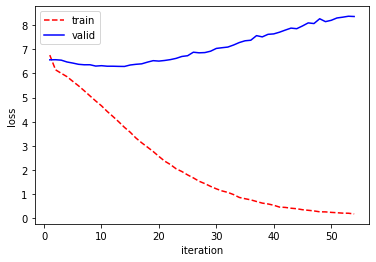

In [46]:
epoch_count = range(1, len(train_history) + 1) 

# Visualize loss history
plt.plot(epoch_count, train_history, 'r--')
plt.plot(epoch_count, valid_history, 'b-')
plt.legend(['train', 'valid'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

What you are experiencing is known as __overfitting__ since the training loss is really small, but the validation error of the model is high. This is due to the model learning “too much” from the training dataset. You probably guess why this happened? We are still training the model on a subsample of the data (`dummy_text`)! If you train the model on the whole dataset, you will definitely get better validation scores. 

### Question 

- Give at least 6 ideas on how you could make your neural language model better (short, bullet-style answers). (You can find inspiration online, for example here: https://arxiv.org/pdf/1708.02182.pdf) 

1. Dropout (using same dropout mask over multiple time steps)
1. (Recurrent) Batch Normalization
1. Limiting updates to the RNN's hidden state
1. Restrictions on the recurrent matrices (capacity or elementwise)
1. Randomized-length backpropagation through time (BPTT)
1. DropConnect
1. Weight tying


**If you had a lot more time (not within the scope of this lab!)**: you've learned the building blocks of neural language models, you can now build the ultimate monster:
* Weight tying: Two weight matrices have been used for input or output respectively (https://arxiv.org/abs/1608.05859)
* Make it char level or maybe use sub-word units like [bpe](https://en.wikipedia.org/wiki/Byte_pair_encoding);
* Use both char-level and word level features to train a word-level language model

### Question

 - Please give us a rough estimation of the hours you invested to complete this session? This will not affect your grade ;) but it might help us with the design of our lab sessions for this new NLP course. 
 
7 hours

## Acknowledgment
If you received help or feedback from fellow students, please acknowledge that here. We count on your academic honesty:

I did not receive any help, I made the whole lab by myself and using the pytorch documentation or solutions from StackOverflow.
